> # Gradcam 
> Visual Explanations from Deep Networks
via Gradient-based Localization

This notebook will run you through an example on how to apply the gradcam algorithm to your trained network.


In [1]:
# First we import libraries needed.

## Standard libraries mostly used for data manipulation and plotting.
import os
import json
import math
import numpy as np 
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import re
import csv
import cv2

## PyTorch & torchvision
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

import torchvision
from torchvision import transforms as transforms

## Custom function to create the models.

def get_top_labels(logits):
    return torch.topk(logits.flatten(),5).indices.cpu().numpy()
def get_top_probs(logits):
    return torch.max(logits.flatten(),5).indices.cpu().numpy()

transform_test = transforms.Compose(
    [transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

#Since we aren't training we will use the cpu

device = torch.device("cpu") # if not torch.cuda.is_available() else torch.device("cuda:0")

In [2]:
# Create the labeldict from our label file
CATEGORIES_PATH = 'data/categories_places365.txt'

labeldict = {}
label_idx_dict = {}
with open(os.path.abspath(CATEGORIES_PATH), 'r') as read_file:
    lines = read_file.readlines()
    for line in lines:
        cleanline = line.strip().split(" ")
        labeldict[int(cleanline[1])] = cleanline[0]
        label_idx_dict[cleanline[0]] = int(cleanline[1])
        

In [3]:
# Create the model and load the trained parameters.
from model import construct_model
CHECKPOINT_PATH = "data/model/Resnet152.pth"
modelname = "ResNet152"




model = construct_model(modelname)
model = model.to(device)

cpt = torch.load(CHECKPOINT_PATH,map_location=torch.device('cpu'))
model.load_state_dict(cpt['checkpoints'][1]['model_state_dict'])


<All keys matched successfully>

In [4]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


count = count_parameters(model)
print(count)

58891629


We have loaded the model.

For this example a Resnet152 Architecture was used using so called Bottleneck Blocks.

At the end of the Resnet instead of some Fully Connected layers we have an average pooling, this is needed for the CAM method, which is a different method to find important regions in the image for certain classes. It is not necessary for the GradCAM method, but since we trained one Network to test different XAI-Methods on we use it in our Network-Architecture.

Let's look at the layers, we can see the different blocks used, throughout the network we decrease the size of each filter, while increasing the amount of them. Our 224x224x3 was transformed into a 16x16x2048 "image". The output can differ depending on your architecture.

In [5]:
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (maxpool): MaxPool2d(kernel_size=(3, 3), stride=2, padding=1, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (layer1): Sequential(
    (0): BottleneckBlock(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     

While Gradcam can use multiple layers the paper suggests that the final layer give the most information on which areas had a positive influence when deciding on a certain class.

Let's thus select the final layer as target layer.

In [6]:
# layer4[-1] means the final block in the last layer. conv3 is the final convolutional filter within this block.
GRADCAM_TARGET_LAYER = model.layer4[-1].conv3

We can now load some images some images and run the GradCAM algorithm on them. Let's look at our image first.

In [72]:
#define some helper functions for loading and transforming the image

# Networks train better on normalized data and the neural network only accepts images of a fixed size.
# We transform our images into an image tensor, resize and normalize them and finally take a random 224x244 crop in training.
# For our tests we manually cropped the images to be quadratic and only have to resize and normalize them here.
# If you want to test this with different images, make sure they are quadratic to ensure correct results.

def get_image(path):
    with open(os.path.abspath(path), 'rb') as f:
        with Image.open(f) as img:
            return img.convert('RGB')
        
transform_test = transforms.Compose(
    [transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])


image_1 = get_image('data/images/lighthouse1.jpg')
image_1_t = transform_test(image_1)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Renormalized input as image')

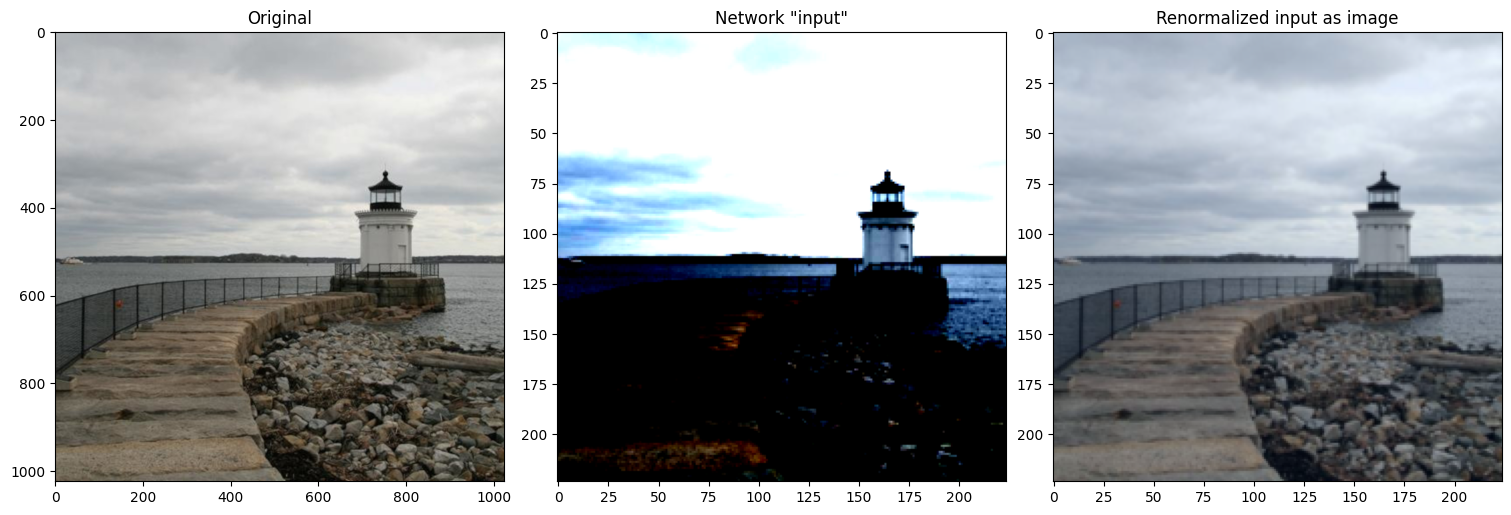

In [73]:
fig, axes = plt.subplots(1,3,constrained_layout = True)
fig.set_figheight(15)
fig.set_figwidth(15)
axes[0].imshow(image_1)
axes[0].set_title("Original")
axes[1].imshow(np.moveaxis(image_1_t.numpy(),0,2))
axes[1].set_title("Network \"input\"")


def normalize_image(img):
    return (img-img.min())/(img.max()-img.min())

axes[2].imshow(normalize_image(np.moveaxis(image_1_t.numpy(),0,2)))
axes[2].set_title("Renormalized input as image")


Note that the middle image isn't really how the network input looks, since we can no longer interpret the data as an RBG image.

The resized image is visibly less detailed, but a human should still have no problem to interpret the image.

In [74]:
# Let's look at the network results for our first image.
# We use unsqueeze to create a batchsize of 1
out = model.eval()(image_1_t.unsqueeze(0))
# we use a softmax so our scores can be interpreted as a percentage of certainty.
out = F.softmax(out,dim=1)
#let's take our result tensor out of the network
logits = out.flatten().detach().cpu()
logits_np = out.flatten().detach().cpu().numpy()
# we can now use our certainties to find the labels with the higest certainty.
top_logits = get_top_labels(logits)
print(top_logits)

[214 266  57 273  49]


In [75]:
## To make sense out of these labels let's use our labeldict

print("Our best label is " + labeldict[top_logits[0]] + " with " + str(logits_np[top_logits[0]]) + " certainty\n")

print("Our top 5 Labels are:\n")
for i in top_logits:
    print(str(i) + " - " + labeldict[i] + " with certainty: " + str(logits_np[i]))


Our best label is /l/lighthouse with 0.6297245 certainty

Our top 5 Labels are:

214 - /l/lighthouse with certainty: 0.6297245
266 - /p/pier with certainty: 0.1346361
57 - /b/boardwalk with certainty: 0.082545824
273 - /p/promenade with certainty: 0.06411566
49 - /b/beach_house with certainty: 0.036984894


As we can see it's not that easy for our network to guess the correct class when faced with many classes with sometimes overlapping concepts.

Most other labels in the Top 5 don't necessarly feel wrong from a human perspective.

Let's try to find out what area of the image was mostly responsible for the decision process of the neural network.

In [76]:
# Let's import what we need for gradcam and define some functions for visualizations
# The gradcam code can be found in the gradcam.py file.

from gradcam import get_gradcam

def mask_on_image(mask,img,alpha=0.5):
    heatmap = get_rgb_heatmap(mask)
    img = img.squeeze()
    cam_on_img = (1-alpha)*img + alpha*heatmap
    return np.copy(cam_on_img)

def get_rgb_heatmap(mask):
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    heatmap = np.float32(heatmap) / 255
    return np.copy(heatmap)


def get_percentage_of_image(mask,image,percentage):
    masked_image = np.zeros_like(image)
    n = mask.size
    sortedvalues = np.sort(mask.flatten('K'))[::-1]
    
    index = int(n/100*percentage)
    index_2 = n//100*percentage
    cutoff = sortedvalues[index]
    for i in range(3):
        masked_image[:,:,i] = np.where(mask-cutoff>0,image[:,:,i],0)
    return masked_image


In [77]:
plot_data = []

#let's get the gradcam mask for the top 5 labels.
for i in top_logits:
    plot_data.append(get_gradcam(model,GRADCAM_TARGET_LAYER,image_1_t.unsqueeze(0),i))


(224, 224)


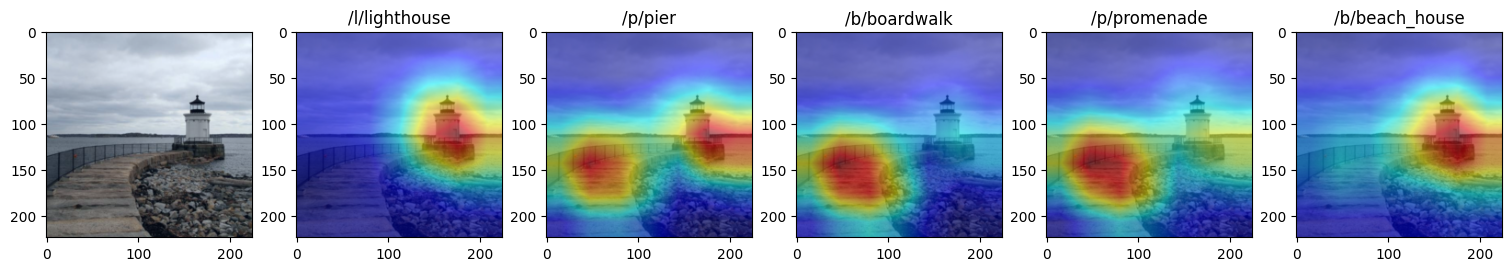

In [80]:
fig, axes = plt.subplots(1,6,constrained_layout = True)
fig.set_figheight(7)
fig.set_figwidth(15)
for i in range(5):
    axes[i+1].imshow(mask_on_image(plot_data[i][0],plot_data[i][1]))
    axes[i+1].set_title(labeldict[top_logits[i]])
axes[0].imshow(plot_data[0][1])
axes[0].imshow(plot_data[0][1])
print(plot_data[i][0].shape)

We can see gradcam highlights different areas for different labels. In particular the lighthouse area is highlighted for the lighthouse and the beach house label.

The pier, boardwalk and promenade label on the other hand have a stronger focus on the left of the image.